In [1]:
# ==== Section 1: Imports & Initial Setup =====================================
# Core
import os
import re
import json
import math
import random
from dataclasses import dataclass, asdict
from datetime import datetime
from pathlib import Path

# Numerics / data
import numpy as np
import pandas as pd
import seaborn as sns
# Torch / vision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import timm

# Utils
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, \
                            accuracy_score, confusion_matrix, brier_score_loss

# Plotting (used later for quick EDA/diagnostics)
import matplotlib.pyplot as plt

In [2]:
def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For reproducibility (slight speed penalty)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_device() -> torch.device:
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")
print(f"Using device: {get_device()}")


Using device: cuda


In [3]:
DATA_DIR = Path("./data").resolve()

In [4]:
DATA_DIR

PosixPath('/home/spandan/projects/btech_cancer/data')

In [5]:
def now_str():
    return datetime.now().strftime("%Y%m%d-%H%M%S")

In [6]:
OUTPUT_ROOT = Path("./outputs").resolve()
RUN_NAME = f"vit_{now_str()}"
RUN_DIR = OUTPUT_ROOT / RUN_NAME
RUN_DIR.mkdir(parents=True, exist_ok=True)

In [7]:
@dataclass
class Config:
    data_dir: Path = DATA_DIR
    output_dir: Path = RUN_DIR
    seed: int = 42
    device: str = str(get_device())
    image_size: int = 224               # 224 to match ResNet/CLIP defaults
    batch_size: int = 64
    num_workers: int = 16
    epochs: int = 50                      # can increase after smoke test
    # base_lr: float = 1e-3
    base_lr: float = 3e-4
    weight_decay: float = 1e-4
    # Aggregation (used later for slide/patient level)
    topk_fraction: float = 0.2           # fraction of tiles used in top-k pooling
    # Mixed precision toggle
    use_amp: bool = True
    # Class names in this Kaggle set
    class_to_idx: dict = None

    def __post_init__(self):
        if self.class_to_idx is None:
            # Kaggle folder names
            self.class_to_idx = {"MSS_JPEG": 0, "MSIMUT_JPEG": 1}

cfg = Config()
set_seed(cfg.seed)
device = torch.device(cfg.device)
with open(cfg.output_dir / "config.json", "w") as f:
    json.dump(asdict(cfg), f, indent=2, default=str)

print(f"Device: {device}")
print(f"Data dir: {cfg.data_dir}")
print(f"Run dir:  {cfg.output_dir}")
print("Config saved to:", cfg.output_dir / "config.json")

Device: cuda
Data dir: /home/spandan/projects/btech_cancer/data
Run dir:  /home/spandan/projects/btech_cancer/outputs/vit_20250827-232342
Config saved to: /home/spandan/projects/btech_cancer/outputs/vit_20250827-232342/config.json


In [8]:
_TCGA_CASE_RE = re.compile(r"(TCGA-[A-Z0-9]{2}-[A-Z0-9]{4})", re.IGNORECASE)
_TCGA_SAMPLE_RE = re.compile(r"(TCGA-[A-Z0-9]{2}-[A-Z0-9]{4}-[0-9A-Z]{2}[A-Z]-[0-9A-Z]{2})", re.IGNORECASE)

def parse_tcga_ids_from_filename(name: str):
    """
    Try to parse TCGA case_id and sample_id from a filename.
    Returns (case_id, sample_id) where sample_id may be None if not found.
    """
    # Strip extension and directories
    base = Path(name).name
    # Try sample-level first
    m_s = _TCGA_SAMPLE_RE.search(base)
    m_c = _TCGA_CASE_RE.search(base)
    sample_id = m_s.group(1) if m_s else None
    case_id = m_c.group(1) if m_c else None
    return case_id, sample_id

In [9]:
from collections import Counter, defaultdict
from sklearn.model_selection import GroupShuffleSplit, GroupKFold

# Sanity: ensure the expected class dirs exist
expected_dirs = ["MSS_JPEG", "MSIMUT_JPEG"]
for d in expected_dirs:
    p = cfg.data_dir / d
    if not p.exists():
        raise FileNotFoundError(
            f"Expected subfolder '{d}' under {cfg.data_dir}, but it wasn't found."
        )


In [10]:
def list_images(root: Path, exts={".jpg", ".jpeg", ".png", ".tif", ".tiff"}):
    files = []
    for cl in expected_dirs:
        class_dir = root / cl
        for ext in exts:
            files.extend(list(class_dir.rglob(f"*{ext}")))
    return sorted(files)

all_files = list_images(cfg.data_dir)
print(f"Found {len(all_files):,} image files.")

rows = []
for fp in all_files:
    label_str = fp.parent.name
    label_idx = cfg.class_to_idx[label_str]
    case_id, sample_id = parse_tcga_ids_from_filename(fp.name)
    # Patient grouping: prefer TCGA case; fallback to stem prefix
    patient_id = case_id if case_id else fp.stem.split("_")[0]
    slide_id = sample_id  # may be None; acceptable for grouping at patient level
    rows.append(
        {
            "path": str(fp.resolve()),
            "label": label_str,
            "label_idx": label_idx,
            "patient_id": patient_id,
            "slide_id": slide_id,
            "fname": fp.name,
        }
    )

df = pd.DataFrame(rows)
df.to_csv(cfg.output_dir / "tiles_index.csv", index=False)
print("Index saved:", cfg.output_dir / "tiles_index.csv")

Found 192,312 image files.
Index saved: /home/spandan/projects/btech_cancer/outputs/vit_20250827-232342/tiles_index.csv


In [11]:
tile_counts = df["label"].value_counts().to_dict()
patient_counts = df.groupby(["patient_id", "label"]).size().reset_index(name="n")
patients_per_class = patient_counts.groupby("label")["patient_id"].nunique().to_dict()

print("\nTile counts by class:", {k: f'{v:,}' for k, v in tile_counts.items()})
print("Unique patients by class:", patients_per_class)
print("Total unique patients:", df["patient_id"].nunique())


Tile counts by class: {'MSS_JPEG': '117,273', 'MSIMUT_JPEG': '75,039'}
Unique patients by class: {'MSIMUT_JPEG': 65, 'MSS_JPEG': 295}
Total unique patients: 360


In [12]:
# Tiles per patient (overall)
tiles_per_patient = df.groupby("patient_id").size()
print("\nTiles per patient: mean="
      f"{tiles_per_patient.mean():.1f}, median={tiles_per_patient.median()}, "
      f"min={tiles_per_patient.min()}, max={tiles_per_patient.max()}")


Tiles per patient: mean=534.2, median=291.5, min=6, max=4305


In [13]:
lbls_per_patient = df.groupby("patient_id")["label_idx"].nunique()
multi_label_patients = (lbls_per_patient > 1).sum()
if multi_label_patients > 0:
    print(f"WARNING: {multi_label_patients} patients have tiles from multiple labels.")

In [14]:
# ------------- Build patient table for stratified grouping -------------------
# Assign each patient a single label by majority (should be unanimous)
pat_label = (
    df.groupby(["patient_id", "label_idx"])
      .size()
      .reset_index(name="n")
      .sort_values(["patient_id", "n"], ascending=[True, False])
      .drop_duplicates(subset=["patient_id"])
      .rename(columns={"label_idx": "patient_label"})
      [["patient_id", "patient_label"]]
)

# Merge back for convenience (not strictly needed)
df = df.merge(pat_label, on="patient_id", how="left")
assert df["patient_label"].isna().sum() == 0

In [15]:
from sklearn.model_selection import train_test_split

seed = cfg.seed

patients = pat_label["patient_id"].values
labels = pat_label["patient_label"].values

# stratify by patient label so MSI/MSS proportions are preserved
train_pat, test_pat = train_test_split(
    patients,
    test_size=0.20,
    stratify=labels,
    random_state=seed,
)

In [16]:
pat_train = pat_label[pat_label["patient_id"].isin(train_pat)].reset_index(drop=True)
pat_test  = pat_label[pat_label["patient_id"].isin(test_pat)].reset_index(drop=True)

print(f"Patients: total={len(pat_label)}, train={len(pat_train)}, test={len(pat_test)}")

Patients: total=360, train=288, test=72


In [17]:
pat_train.to_csv(cfg.output_dir / "patients_train.csv", index=False)
pat_test.to_csv(cfg.output_dir / "patients_test.csv", index=False)
print("Saved:", cfg.output_dir / "patients_train.csv")
print("Saved:", cfg.output_dir / "patients_test.csv")

Saved: /home/spandan/projects/btech_cancer/outputs/vit_20250827-232342/patients_train.csv
Saved: /home/spandan/projects/btech_cancer/outputs/vit_20250827-232342/patients_test.csv


In [18]:
df["split"] = "train"
df.loc[df["patient_id"].isin(pat_test["patient_id"]), "split"] = "test"

# Persist tile index with split labels
df.to_csv(cfg.output_dir / "tiles_with_splits.csv", index=False)
print("Tile-level index with splits saved:", cfg.output_dir / "tiles_with_splits.csv")

Tile-level index with splits saved: /home/spandan/projects/btech_cancer/outputs/vit_20250827-232342/tiles_with_splits.csv


In [19]:
def summarize_split(pat_df, name):
    counts = pat_df["patient_label"].value_counts().to_dict()
    counts_named = {0: "MSS", 1: "MSI"}
    pretty = {counts_named.get(k, k): v for k, v in counts.items()}
    print(f"{name}: patients by class -> {pretty}")

summarize_split(pat_train, "Train")
summarize_split(pat_test, "Test")

# Optional: tile-level class counts per split
tile_split_counts = (
    df.groupby(["split", "label_idx"])
      .size()
      .unstack(fill_value=0)
      .rename(columns={0: "MSS_tiles", 1: "MSI_tiles"})
)
print("\nTile counts by split:")
print(tile_split_counts)

Train: patients by class -> {'MSS': 236, 'MSI': 52}
Test: patients by class -> {'MSS': 59, 'MSI': 13}

Tile counts by split:
label_idx  MSS_tiles  MSI_tiles
split                          
test           29530      17833
train          87743      57206


/tmp/ipykernel_229536/2159398673.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", order=["MSS_JPEG","MSIMUT_JPEG"], palette="Set2")


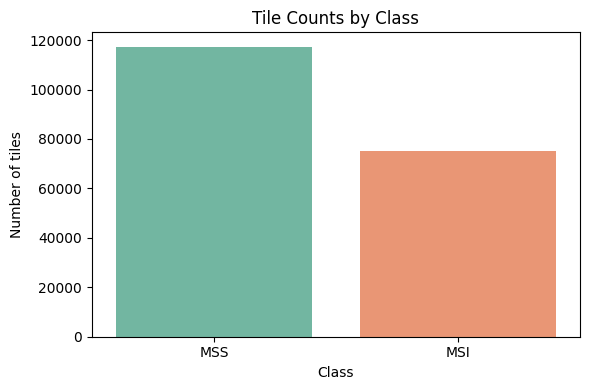

In [20]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="label", order=["MSS_JPEG","MSIMUT_JPEG"], palette="Set2")
plt.title("Tile Counts by Class")
plt.ylabel("Number of tiles")
plt.xlabel("Class")
plt.xticks([0,1], ["MSS", "MSI"])
plt.tight_layout()
plt.show()


/tmp/ipykernel_229536/3569350310.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="patient_label", data=pat_label, palette="Set1")


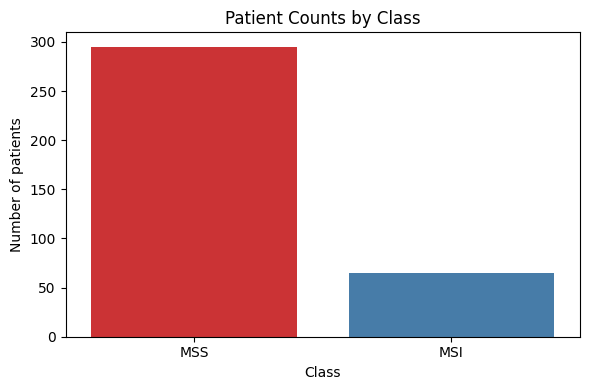

In [21]:
plt.figure(figsize=(6,4))
sns.countplot(x="patient_label", data=pat_label, palette="Set1")
plt.title("Patient Counts by Class")
plt.ylabel("Number of patients")
plt.xlabel("Class")
plt.xticks([0,1], ["MSS", "MSI"])
plt.tight_layout()
plt.show()

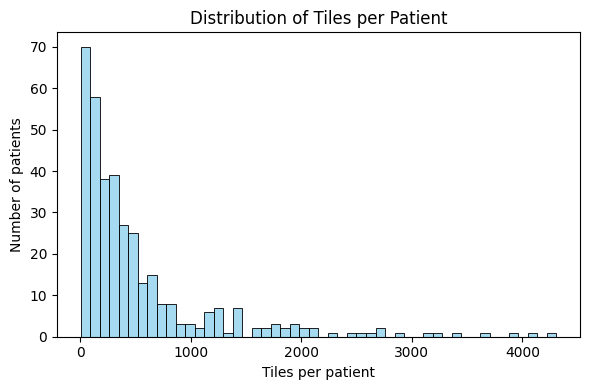

In [22]:
tiles_per_patient = df.groupby("patient_id").size()
plt.figure(figsize=(6,4))
sns.histplot(tiles_per_patient, bins=50, kde=False, color="skyblue")
plt.title("Distribution of Tiles per Patient")
plt.xlabel("Tiles per patient")
plt.ylabel("Number of patients")
plt.tight_layout()
plt.show()

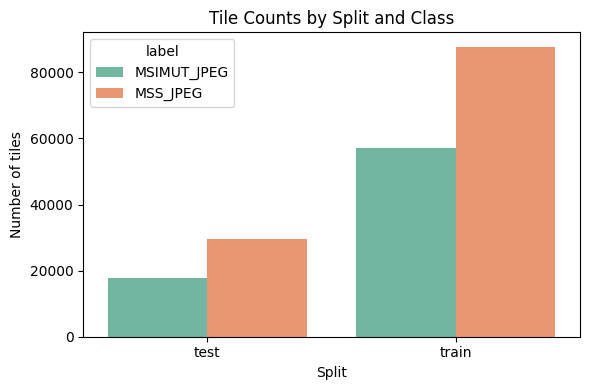

In [23]:
split_summary = (
    df.groupby(["split", "label"])
      .size()
      .reset_index(name="count")
)
plt.figure(figsize=(6,4))
sns.barplot(data=split_summary, x="split", y="count", hue="label", palette="Set2")
plt.title("Tile Counts by Split and Class")
plt.ylabel("Number of tiles")
plt.xlabel("Split")
plt.tight_layout()
plt.show()


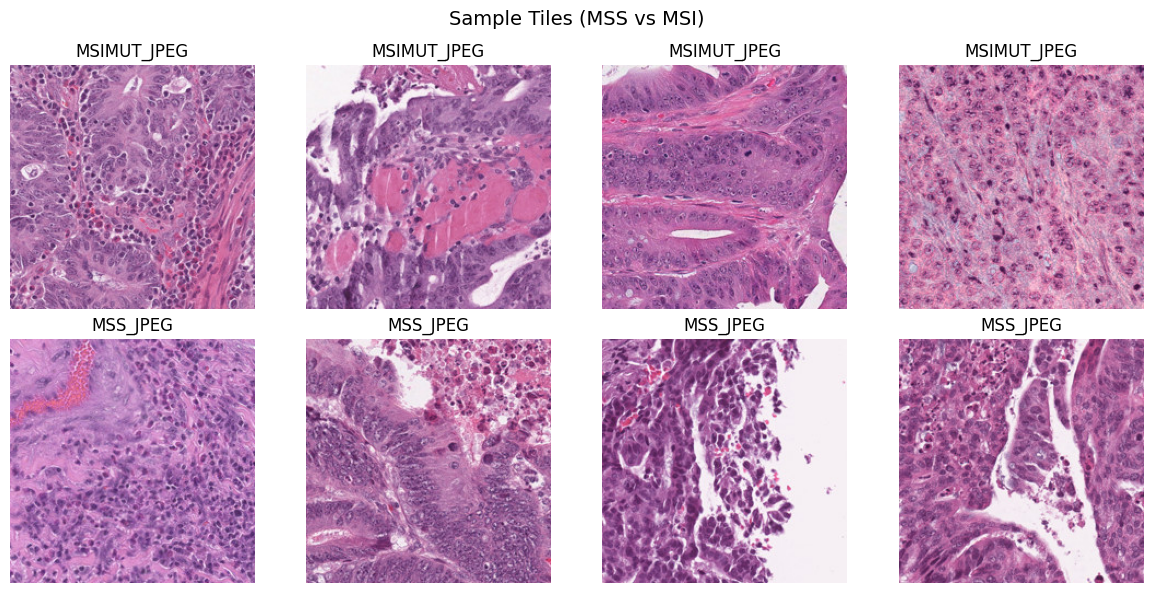

In [24]:
from PIL import Image
sample_paths = df.groupby("label").head(4)["path"].tolist()

fig, axes = plt.subplots(2, 4, figsize=(12,6))
for i, path in enumerate(sample_paths):
    img = Image.open(path)
    ax = axes[i//4, i%4]
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(Path(path).parent.name)
plt.suptitle("Sample Tiles (MSS vs MSI)", fontsize=14)
plt.tight_layout()
plt.show()

Computing mean colors: 100%|██████████| 2000/2000 [00:02<00:00, 671.14it/s]


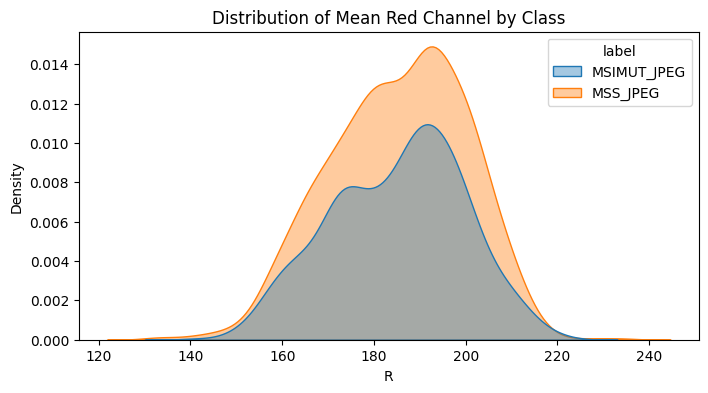

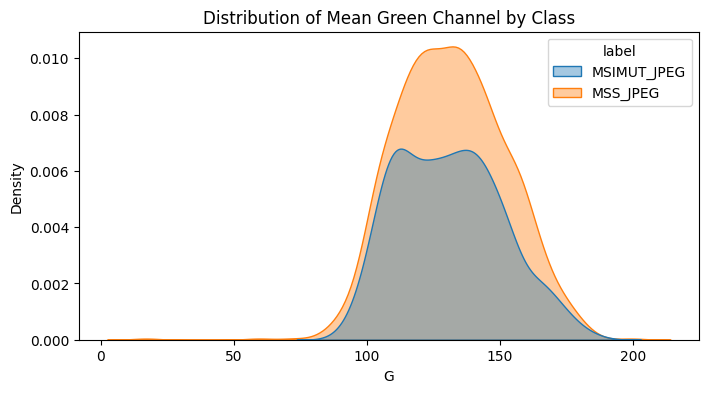

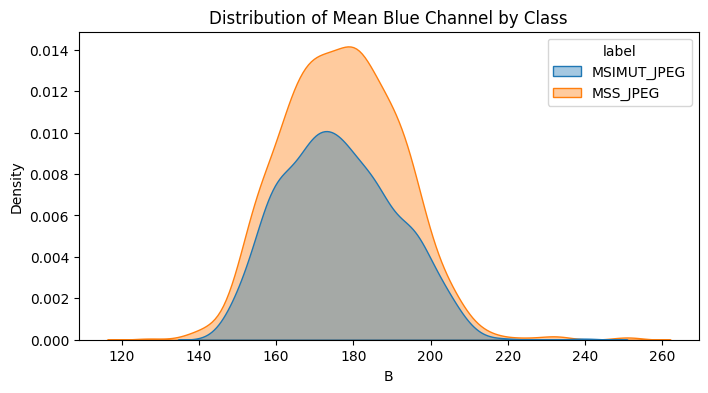

In [25]:
# Compute mean RGB per image for a sample subset
subset = df.sample(2000, random_state=cfg.seed)  # sample for speed
means = []
for path in tqdm(subset["path"], desc="Computing mean colors"):
    img = np.array(Image.open(path).convert("RGB"))
    means.append(img.mean(axis=(0,1)))
means = np.array(means)
subset = subset.assign(R=means[:,0], G=means[:,1], B=means[:,2])

plt.figure(figsize=(8,4))
sns.kdeplot(data=subset, x="R", hue="label", fill=True, alpha=0.4)
plt.title("Distribution of Mean Red Channel by Class")
plt.show()

plt.figure(figsize=(8,4))
sns.kdeplot(data=subset, x="G", hue="label", fill=True, alpha=0.4)
plt.title("Distribution of Mean Green Channel by Class")
plt.show()

plt.figure(figsize=(8,4))
sns.kdeplot(data=subset, x="B", hue="label", fill=True, alpha=0.4)
plt.title("Distribution of Mean Blue Channel by Class")
plt.show()


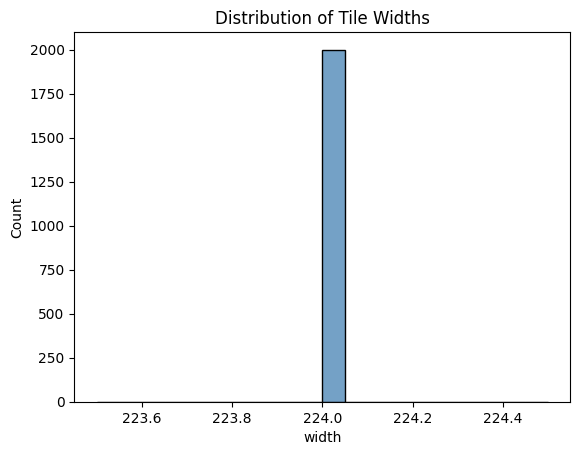

In [26]:
dims = []
for path in df.sample(2000, random_state=cfg.seed)["path"]:
    with Image.open(path) as im:
        dims.append(im.size)
dims = pd.DataFrame(dims, columns=["width","height"])
sns.histplot(dims["width"], bins=20, color="steelblue", kde=False)
plt.title("Distribution of Tile Widths")
plt.show()


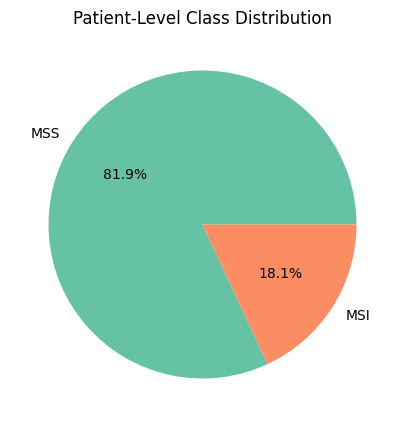

In [27]:
plt.figure(figsize=(5,5))
pat_label["patient_label"].map({0:"MSS",1:"MSI"}).value_counts().plot.pie(
    autopct="%1.1f%%", colors=["#66c2a5","#fc8d62"]
)
plt.title("Patient-Level Class Distribution")
plt.ylabel("")
plt.show()


In [28]:
tiles_per_patient = df.groupby("patient_id").size().reset_index(name="n_tiles")
outliers = tiles_per_patient.sort_values("n_tiles", ascending=False).head(10)
print("Top 10 patients by number of tiles:\n", outliers)


Top 10 patients by number of tiles:
        patient_id  n_tiles
225  TCGA-CM-6171     4305
202  TCGA-CM-4743     4064
160  TCGA-AY-A71X     3914
356  TCGA-QG-A5Z2     3682
204  TCGA-CM-4746     3360
267  TCGA-DC-6681     3218
237  TCGA-D5-6530     3105
350  TCGA-NH-A5IV     2888
326  TCGA-F5-6810     2754
309  TCGA-F4-6460     2752


In [29]:
train_counts = df[df["split"]=="train"]["label"].value_counts()
test_counts  = df[df["split"]=="test"]["label"].value_counts()
print("Train tile counts:\n", train_counts)
print("Test tile counts:\n", test_counts)


Train tile counts:
 label
MSS_JPEG       87743
MSIMUT_JPEG    57206
Name: count, dtype: int64
Test tile counts:
 label
MSS_JPEG       29530
MSIMUT_JPEG    17833
Name: count, dtype: int64


In [30]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [31]:
def is_blurry(img: Image.Image, thresh: float = 100.0) -> bool:
    """Simple blur detection using variance of Laplacian."""
    import cv2
    gray = np.array(img.convert("L"))
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    return fm < thresh


In [32]:
class HistologyDataset(Dataset):
    def __init__(self, df: pd.DataFrame, split: str, cfg: Config, augment: bool = False, transform=None):
        """
        If `transform` is provided (e.g., from timm), it takes precedence.
        Otherwise falls back to the internal torchvision pipeline.
        """
        self.df = df[df["split"] == split].reset_index(drop=True)
        self.cfg = cfg
        self.augment = augment

        if transform is not None:
            self.transform = transform
        else:
            if augment:
                self.transform = transforms.Compose([
                    transforms.RandomResizedCrop(cfg.image_size, scale=(0.8, 1.0)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomVerticalFlip(),
                    transforms.RandomRotation(90),
                    transforms.ColorJitter(brightness=0.2, contrast=0.2,
                                           saturation=0.2, hue=0.05),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]),
                ])
            else:
                self.transform = transforms.Compose([
                    transforms.Resize((self.cfg.image_size, self.cfg.image_size)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]),
                ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["path"]).convert("RGB")

        # Optional blur filtering if you enable it
        # if is_blurry(img):
        #     return None

        img = self.transform(img)
        label = row["label_idx"]
        return img, label, row["patient_id"], row["fname"]


In [33]:
def collate_fn(batch):
    # Remove None entries (if blur filtering used)
    batch = [b for b in batch if b is not None]
    if len(batch) == 0:
        return None
    imgs, labels, patient_ids, fnames = zip(*batch)
    return torch.stack(imgs), torch.tensor(labels), list(patient_ids), list(fnames)

In [34]:
import torchvision
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

In [35]:
class VisionTransformerTIMM(nn.Module):
    def __init__(self, num_classes: int = 2,
                 model_name: str = "deit_small_patch16_224",
                 pretrained: bool = True,
                 dropout: float = 0.1,
                 drop_path: float = 0.1):
        super().__init__()
        # timm attaches a classifier head with `num_classes`
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=num_classes,
            drop_rate=dropout,          # classifier/MLP dropout
            drop_path_rate=drop_path    # stochastic depth
        )

    def forward(self, x):
        return self.backbone(x)


In [36]:
# ----------------------- Class weights (to combat imbalance) -----------------
# Compute weights from the TRAIN split at the TILE level (proxy to patient imbalance).
train_counts = df[df["split"] == "train"]["label_idx"].value_counts().sort_index()
num_classes = 2
class_counts = torch.tensor([train_counts.get(i, 0) for i in range(num_classes)], dtype=torch.float32)
# Effective number of samples (optional); here we use simple inverse frequency
eps = 1e-6
inv_freq = 1.0 / (class_counts + eps)
class_weights = (inv_freq / inv_freq.sum() * num_classes).to(device)  # normalized
print("Class counts (train tiles):", class_counts.tolist())
print("Class weights:", class_weights.tolist())

Class counts (train tiles): [87743.0, 57206.0]
Class weights: [0.7893258929252625, 1.2106740474700928]


In [37]:
# model = ResNet50Baseline(num_classes=2, pretrained=True, dropout=0.2).to(device)

In [38]:
model = VisionTransformerTIMM(
    num_classes=2,
    model_name="swin_tiny_patch4_window7_224",  # or "swin_small_patch4_window7_224"
    pretrained=True,
    dropout=0.0,     # Swin often uses less head dropout
    drop_path=0.2    # Swin benefits from higher drop-path
).to(device)


In [39]:
from timm.data import resolve_model_data_config
from timm.data.transforms_factory import create_transform

def build_timm_transforms(backbone) -> tuple:
    """
    Returns (train_tfms, val_tfms) that match the given timm backbone.
    Call this AFTER you instantiate your model (so backbone exists).
    """
    data_cfg = resolve_model_data_config(backbone)

    train_tfms = create_transform(
        input_size=data_cfg['input_size'],
        is_training=True,
        mean=data_cfg['mean'],
        std=data_cfg['std'],
        interpolation=data_cfg.get('interpolation', 'bilinear'),
        crop_pct=None
    )
    val_tfms = create_transform(
        input_size=data_cfg['input_size'],
        is_training=False,
        mean=data_cfg['mean'],
        std=data_cfg['std'],
        interpolation=data_cfg.get('interpolation', 'bilinear'),
        crop_pct=data_cfg.get('crop_pct', None)
    )
    return train_tfms, val_tfms


In [40]:
# Loss with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [41]:
optimizer = optim.AdamW(model.parameters(), lr=cfg.base_lr, weight_decay=cfg.weight_decay)

In [42]:
# Scheduler: Cosine decay over total epochs (no T_max restarts), optional warmup steps handled in loop
scheduler = CosineAnnealingLR(optimizer, T_max=cfg.epochs)

In [43]:
# Mixed precision scaler
scaler = torch.amp.GradScaler('cuda', enabled=cfg.use_amp and device.type == "cuda")

In [44]:
n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model: {model.__class__.__name__}, trainable params: {n_params/1e6:.1f}M")

Model: VisionTransformerTIMM, trainable params: 27.5M


In [45]:
import time
import warnings
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, \
                            accuracy_score, confusion_matrix, classification_report, \
                            brier_score_loss

In [46]:
def safe_auroc(y_true, y_score):
    try:
        return roc_auc_score(y_true, y_score)
    except Exception:
        return float("nan")

def safe_auprc(y_true, y_score):
    try:
        return average_precision_score(y_true, y_score)
    except Exception:
        return float("nan")

def compute_classification_metrics(y_true, y_score, thresh=0.5):
    y_pred = (np.array(y_score) >= thresh).astype(int)
    metrics = {
        "auroc": safe_auroc(y_true, y_score),
        "auprc": safe_auprc(y_true, y_score),
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "brier": brier_score_loss(y_true, y_score),
    }
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    return metrics, cm, y_pred

def topk_mean(prob_list, k_frac=0.2):
    if len(prob_list) == 0:
        return float("nan")
    k = max(1, int(round(k_frac * len(prob_list))))
    topk = np.sort(prob_list)[-k:]
    return float(np.mean(topk))

def aggregate_patient_probs(tile_df, k_frac=0.2):
    """
    tile_df must contain: columns ['patient_id','y_true','y_score']
    Returns DataFrame with one row per patient and aggregated probability.
    """
    agg_rows = []
    for pid, sub in tile_df.groupby("patient_id"):
        y_true_pat = int(sub["y_true"].iloc[0])  # patient-level label (assumed consistent)
        p = topk_mean(sub["y_score"].values, k_frac=k_frac)
        agg_rows.append({"patient_id": pid, "y_true": y_true_pat, "y_score": p})
    return pd.DataFrame(agg_rows)


In [47]:
# ==== Section 5a: Build a Validation Split from Train (patient-wise) =========
from sklearn.model_selection import train_test_split

# Build patient tables if you don't still have them in memory:
# (We have pat_label already; now split train patients into train/val)
train_patients_all = df.loc[df["split"]=="train", "patient_id"].unique()
train_patient_labels = (
    df.loc[df["split"]=="train", ["patient_id","patient_label"]]
      .drop_duplicates()["patient_label"].values
)

train_pat, val_pat = train_test_split(
    train_patients_all,
    test_size=0.10,               # 10% of training patients for validation
    stratify=train_patient_labels, # stratify by patient label
    random_state=cfg.seed
)

# Mark val in df (patient-wise)
df["split_detail"] = None
df.loc[df["split"]=="train", "split_detail"] = "train_main"
df.loc[df["patient_id"].isin(val_pat), "split_detail"] = "val"
df.loc[df["patient_id"].isin(train_pat), "split_detail"] = "train_main"

# Quick sanity check
print("Train patients:", len(train_pat), "Val patients:", len(val_pat))
print(df["split_detail"].value_counts(dropna=False))


Train patients: 259 Val patients: 29
split_detail
train_main    131849
None           47363
val            13100
Name: count, dtype: int64


In [48]:
# ==== Section 5b: Build Train/Val DataLoaders ================================
class HistologyDatasetSplit(HistologyDataset):
    """
    Same dataset, but selects by split_detail within the global 'train' split.
    Accepts optional `transform` (e.g., timm transform).
    """
    def __init__(self, df: pd.DataFrame, split_detail: str, cfg: Config, augment: bool, transform=None):
        df_use = df[(df["split"] == "train") & (df["split_detail"] == split_detail)].reset_index(drop=True)
        # Call parent with an explicit split ("train") but pass the pre-filtered df
        # We override self.df below to ensure we use df_use
        super().__init__(df, split="train", cfg=cfg, augment=augment, transform=transform)
        self.df = df_use






In [49]:
# --- Build transforms from the already-instantiated timm model ---
# (Assumes: model = VisionTransformerTIMM(...).to(device) was created above)
train_tfms, val_tfms = build_timm_transforms(model.backbone)

# --- Datasets (use the split_detail-aware class so train excludes val) ---
train_dataset_main = HistologyDatasetSplit(
    df, split_detail="train_main", cfg=cfg, augment=True, transform=train_tfms
)
val_dataset = HistologyDatasetSplit(
    df, split_detail="val", cfg=cfg, augment=False, transform=val_tfms
)
test_dataset = HistologyDataset(
    df, split="test", cfg=cfg, augment=False, transform=val_tfms
)

In [50]:
# --- DataLoaders ---
train_loader = DataLoader(
    train_dataset_main,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers,
    pin_memory=True,
    collate_fn=collate_fn,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=True,
    collate_fn=collate_fn,
)
test_loader = DataLoader(
    test_dataset,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=True,
    collate_fn=collate_fn,
)

print(
    f"Train (main) batches: {len(train_loader)}, "
    f"Val batches: {len(val_loader)}, "
    f"Test batches: {len(test_loader)}"
)

# (Optional) quick sanity batch
xb, yb, pids, fnames = next(iter(train_loader))
print("Example batch → Images:", xb.shape, "Labels:", yb.shape)

Train (main) batches: 2061, Val batches: 205, Test batches: 741
Example batch → Images: torch.Size([64, 3, 224, 224]) Labels: torch.Size([64])


In [51]:
# ==== Section 5c: EarlyStopping Helper ======================================
class EarlyStopping:
    def __init__(self, mode="max", patience=3, min_delta=0.0, restore_best=True):
        assert mode in ["max", "min"]
        self.mode = mode
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best = restore_best
        self.best = None
        self.num_bad = 0
        self.best_state = None

    def step(self, value, model):
        improved = False
        if self.best is None:
            improved = True
        else:
            if self.mode == "max":
                improved = (value - self.best) > self.min_delta
            else:
                improved = (self.best - value) > self.min_delta

        if improved:
            self.best = value
            self.num_bad = 0
            if self.restore_best:
                # store a deepcopy of model state dict
                self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        else:
            self.num_bad += 1

        stop = self.num_bad > self.patience
        return stop

    def restore(self, model):
        if self.restore_best and self.best_state is not None:
            model.load_state_dict(self.best_state)


In [52]:
def train_one_epoch(model, loader, optimizer, criterion, scaler, device):
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0

    pbar = tqdm(loader, desc="Train", leave=False)
    for batch in pbar:
        if batch is None:
            continue  # in case blur filtering removed all items
        xb, yb, _, _ = batch
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast('cuda', enabled=(cfg.use_amp and device.type == "cuda")):
            logits = model(xb)
            loss = criterion(logits, yb)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        with torch.no_grad():
            preds = logits.argmax(dim=1)
            running_loss += loss.item() * xb.size(0)
            running_correct += (preds == yb).sum().item()
            running_total += xb.size(0)

        pbar.set_postfix({
            "loss": f"{running_loss / max(1, running_total):.4f}",
            "acc": f"{running_correct / max(1, running_total):.3f}"
        })

    epoch_loss = running_loss / max(1, running_total)
    epoch_acc = running_correct / max(1, running_total)
    return epoch_loss, epoch_acc

In [53]:
@torch.no_grad()
def predict_loader(model, loader, device):
    model.eval()
    all_scores = []
    all_labels = []
    all_pids = []
    all_fnames = []

    pbar = tqdm(loader, desc="Eval", leave=False)
    for batch in pbar:
        if batch is None:
            continue
        xb, yb, pids, fnames = batch
        xb = xb.to(device, non_blocking=True)

        with torch.amp.autocast('cuda', enabled=(cfg.use_amp and device.type == "cuda")):
            logits = model(xb)
            probs = torch.softmax(logits, dim=1)[:, 1]  # MSI probability (class 1)

        all_scores.extend(probs.detach().cpu().tolist())
        all_labels.extend(yb.numpy().tolist())
        all_pids.extend(pids)
        all_fnames.extend(fnames)

    pred_df = pd.DataFrame({
        "fname": all_fnames,
        "patient_id": all_pids,
        "y_true": all_labels,
        "y_score": all_scores
    })
    return pred_df

In [54]:
history = []
best_state = None
best_metric = -np.inf

In [55]:
for epoch in range(1, cfg.epochs + 1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler, device)
    scheduler.step()

    elapsed = time.time() - t0
    hist_row = {"epoch": epoch, "train_loss": train_loss, "train_acc": train_acc, "time_sec": elapsed}
    history.append(hist_row)
    print(f"[Epoch {epoch:02d}] loss={train_loss:.4f} acc={train_acc:.3f} time={elapsed:.1f}s")

# Save final checkpoint
ckpt_path = cfg.output_dir / "model_final.pth"
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "scheduler_state_dict": scheduler.state_dict(),
    "cfg": asdict(cfg),
    "history": history
}, ckpt_path)
print("Saved model checkpoint to:", ckpt_path)

[Epoch 01] loss=0.6632 acc=0.604 time=524.1s


[Epoch 02] loss=0.6278 acc=0.653 time=523.1s


[Epoch 03] loss=0.5921 acc=0.685 time=523.8s


[Epoch 04] loss=0.5531 acc=0.714 time=519.8s


[Epoch 05] loss=0.5221 acc=0.737 time=523.2s


[Epoch 06] loss=0.4996 acc=0.751 time=522.3s


[Epoch 07] loss=0.4781 acc=0.767 time=523.6s


[Epoch 08] loss=0.4546 acc=0.781 time=526.0s


[Epoch 09] loss=0.4356 acc=0.792 time=524.0s


[Epoch 10] loss=0.4249 acc=0.796 time=522.6s


[Epoch 11] loss=0.4063 acc=0.808 time=520.2s


[Epoch 12] loss=0.3908 acc=0.816 time=522.1s


[Epoch 13] loss=0.3771 acc=0.824 time=521.4s


[Epoch 14] loss=0.3651 acc=0.830 time=522.2s


[Epoch 15] loss=0.3535 acc=0.838 time=522.2s


[Epoch 16] loss=0.3420 acc=0.842 time=522.5s


[Epoch 17] loss=0.3316 acc=0.849 time=520.0s


[Epoch 18] loss=0.3200 acc=0.853 time=521.7s


[Epoch 19] loss=0.3096 acc=0.859 time=521.7s


[Epoch 20] loss=0.3011 acc=0.862 time=521.3s


[Epoch 21] loss=0.2937 acc=0.868 time=521.8s


[Epoch 22] loss=0.2842 acc=0.873 time=522.1s


[Epoch 23] loss=0.2736 acc=0.877 time=520.4s


[Epoch 24] loss=0.2670 acc=0.881 time=521.5s


[Epoch 25] loss=0.2586 acc=0.884 time=522.2s


[Epoch 26] loss=0.2519 acc=0.888 time=521.9s


[Epoch 27] loss=0.2432 acc=0.891 time=521.7s


KeyboardInterrupt: 

In [ ]:
test_pred_tiles = predict_loader(model, test_loader, device)

# Attach paths and labels for convenience (join with df by fname+patient)
# Note: fname should be unique in practice; if not, merge on ['fname','patient_id'].
tile_meta = df[["fname","path","patient_id","label_idx","split"]]
test_pred_tiles = test_pred_tiles.merge(tile_meta, on=["fname","patient_id"], how="left")
test_pred_tiles = test_pred_tiles[test_pred_tiles["split"] == "test"].copy()


In [ ]:
tile_metrics, tile_cm, tile_pred = compute_classification_metrics(
    test_pred_tiles["y_true"].values, test_pred_tiles["y_score"].values, thresh=0.5
)
print("\n=== Tile-level metrics (TEST) ===")
for k, v in tile_metrics.items():
    print(f"{k}: {v:.4f}")
print("Confusion matrix (tiles) [rows=true MSS,MSI ; cols=pred MSS,MSI]:\n", tile_cm)



=== Tile-level metrics (TEST) ===
auroc: 0.5764
auprc: 0.4759
accuracy: 0.6129
f1: 0.4150
brier: 0.2881
Confusion matrix (tiles) [rows=true MSS,MSI ; cols=pred MSS,MSI]:
 [[22528  7002]
 [11330  6503]]


In [ ]:
# Patient-level aggregation (top-k mean)
test_patients_df = aggregate_patient_probs(test_pred_tiles[["patient_id","y_true","y_score"]], 
                                           k_frac=cfg.topk_fraction)
pat_metrics, pat_cm, pat_pred = compute_classification_metrics(
    test_patients_df["y_true"].values, test_patients_df["y_score"].values, thresh=0.5
)
print("\n=== Patient-level metrics (TEST, top-k aggregation) ===")
for k, v in pat_metrics.items():
    print(f"{k}: {v:.4f}")
print("Confusion matrix (patients) [rows=true MSS,MSI ; cols=pred MSS,MSI]:\n", pat_cm)


=== Patient-level metrics (TEST, top-k aggregation) ===
auroc: 0.7301
auprc: 0.5171
accuracy: 0.3333
f1: 0.3143
brier: 0.4104
Confusion matrix (patients) [rows=true MSS,MSI ; cols=pred MSS,MSI]:
 [[13 46]
 [ 2 11]]


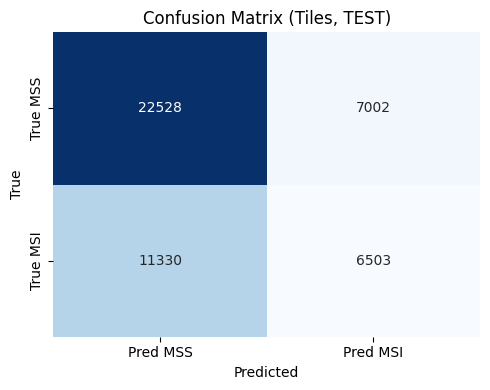

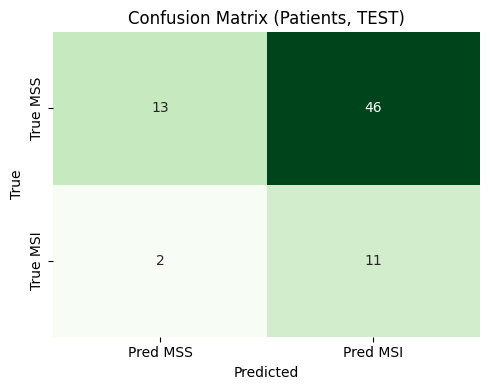

In [ ]:
# Tile-level CM
plt.figure(figsize=(5,4))
sns.heatmap(tile_cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pred MSS","Pred MSI"],
            yticklabels=["True MSS","True MSI"])
plt.title("Confusion Matrix (Tiles, TEST)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Patient-level CM
plt.figure(figsize=(5,4))
sns.heatmap(pat_cm, annot=True, fmt="d", cmap="Greens", cbar=False,
            xticklabels=["Pred MSS","Pred MSI"],
            yticklabels=["True MSS","True MSI"])
plt.title("Confusion Matrix (Patients, TEST)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [ ]:
# Tile-level CSV
tile_csv = cfg.output_dir / "test_tile_predictions.csv"
test_pred_tiles[["fname","path","patient_id","y_true","y_score"]].to_csv(tile_csv, index=False)
print("Saved tile predictions to:", tile_csv)


Saved tile predictions to: /home/spandan/projects/btech_cancer/outputs/resnet50_baseline_20250826-003911/test_tile_predictions.csv


In [ ]:
pat_csv = cfg.output_dir / "test_patient_predictions.csv"
out_pat = test_patients_df.copy()
out_pat["y_pred"] = (out_pat["y_score"] >= 0.5).astype(int)
out_pat.to_csv(pat_csv, index=False)
print("Saved patient predictions to:", pat_csv)

Saved patient predictions to: /home/spandan/projects/btech_cancer/outputs/resnet50_baseline_20250826-003911/test_patient_predictions.csv


In [ ]:
cfg_dict = asdict(cfg)
cfg_dict["data_dir"] = str(cfg_dict["data_dir"])
cfg_dict["output_dir"] = str(cfg_dict["output_dir"])

metrics_json = {
    "tile": tile_metrics,
    "patient": pat_metrics,
    "cfg": cfg_dict
}

with open(cfg.output_dir / "metrics_test.json", "w") as f:
    json.dump(metrics_json, f, indent=2)

print("Saved metrics JSON to:", cfg.output_dir / "metrics_test.json")


Saved metrics JSON to: /home/spandan/projects/btech_cancer/outputs/resnet50_baseline_20250826-003911/metrics_test.json


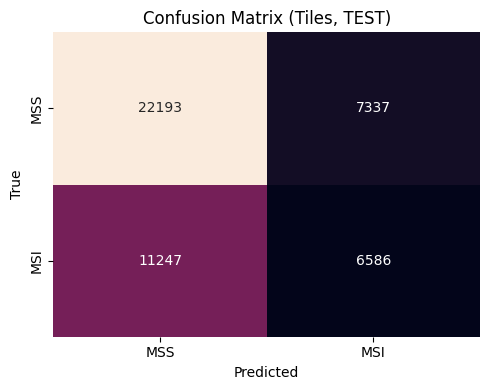

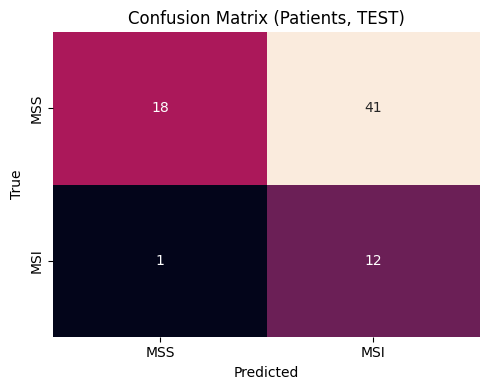

In [ ]:
plt.figure(figsize=(5,4))
sns.heatmap(tile_cm, annot=True, fmt="d", cbar=False, 
            xticklabels=["MSS","MSI"], yticklabels=["MSS","MSI"])
plt.title("Confusion Matrix (Tiles, TEST)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
sns.heatmap(pat_cm, annot=True, fmt="d", cbar=False, 
            xticklabels=["MSS","MSI"], yticklabels=["MSS","MSI"])
plt.title("Confusion Matrix (Patients, TEST)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [ ]:
# ==== Section 5d: Train with Validation, Monitor Patient AUROC, Early Stop ===
def evaluate_patient_level(model, loader, device, k_frac=0.2):
    """Compute tile- and patient-level metrics on a loader."""
    pred_tiles = predict_loader(model, loader, device)  # returns fname, patient_id, y_true, y_score
    # join to meta to ensure we keep correct labels
    tile_meta = df[["fname","path","patient_id","label_idx"]]
    pred_tiles = pred_tiles.merge(tile_meta, on=["fname","patient_id"], how="left")
    # Tile-level metrics
    tile_metrics, tile_cm, _ = compute_classification_metrics(
        pred_tiles["y_true"].values, pred_tiles["y_score"].values, thresh=0.5
    )
    # Patient-level
    pat_df = aggregate_patient_probs(pred_tiles[["patient_id","y_true","y_score"]], k_frac=k_frac)
    pat_metrics, pat_cm, _ = compute_classification_metrics(
        pat_df["y_true"].values, pat_df["y_score"].values, thresh=0.5
    )
    return {
        "tile": {"metrics": tile_metrics, "cm": tile_cm, "preds": pred_tiles},
        "patient": {"metrics": pat_metrics, "cm": pat_cm, "preds": pat_df},
    }

# Early stopping config
early = EarlyStopping(mode="max", patience=3, min_delta=1e-4, restore_best=True)

history = []
best_ckpt_path = cfg.output_dir / "model_best.pth"

for epoch in range(1, cfg.epochs + 1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler, device)
    scheduler.step()

    # ---- Validation pass (patient-level AUROC monitor) ----
    val_res = evaluate_patient_level(model, val_loader, device, k_frac=cfg.topk_fraction)
    val_tile = val_res["tile"]["metrics"]
    val_pat  = val_res["patient"]["metrics"]
    elapsed = time.time() - t0

    hist_row = {
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_tile_auroc": float(val_tile["auroc"]),
        "val_tile_auprc": float(val_tile["auprc"]),
        "val_pat_auroc": float(val_pat["auroc"]),
        "val_pat_auprc": float(val_pat["auprc"]),
        "time_sec": elapsed
    }
    history.append(hist_row)

    print(f"[Epoch {epoch:02d}] loss={train_loss:.4f} acc={train_acc:.3f} "
          f"val_pat_auroc={val_pat['auroc']:.4f} val_pat_auprc={val_pat['auprc']:.4f} "
          f"time={elapsed:.1f}s")   

    # Save checkpoint each epoch
    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state_dict": scheduler.state_dict(),
        "cfg": asdict(cfg),
        "history": history
    }, cfg.output_dir / f"model_epoch_{epoch:02d}.pth")

    # Early stopping step on patient-level AUROC
    stop = early.step(val_pat["auroc"], model)
    if stop:
        print(f"Early stopping triggered at epoch {epoch}. Restoring best weights.")
        early.restore(model)
        break

# Save best after training/early stop
torch.save({
    "model_state_dict": model.state_dict(),
    "cfg": asdict(cfg),
    "history": history,
    "best_val_pat_auroc": early.best
}, best_ckpt_path)
print("Saved best model checkpoint to:", best_ckpt_path)


[Epoch 01] loss=0.1446 acc=0.940 val_pat_auroc=0.9833 val_pat_auprc=0.9267 time=383.8s


KeyboardInterrupt: 

In [ ]:
# ==== Section 5e: Final Test Evaluation with Best Weights ====================
# Evaluate on TEST split with restored best weights
test_pred_tiles = predict_loader(model, test_loader, device)
tile_meta = df[["fname","path","patient_id","label_idx","split"]]
test_pred_tiles = test_pred_tiles.merge(tile_meta, on=["fname","patient_id"], how="left")
test_pred_tiles = test_pred_tiles[test_pred_tiles["split"] == "test"].copy()

tile_metrics, tile_cm, tile_pred = compute_classification_metrics(
    test_pred_tiles["y_true"].values, test_pred_tiles["y_score"].values, thresh=0.5
)
print("\n=== Tile-level metrics (TEST, best model) ===")
for k, v in tile_metrics.items():
    print(f"{k}: {v:.4f}")
print("Confusion matrix (tiles):\n", tile_cm)

test_patients_df = aggregate_patient_probs(test_pred_tiles[["patient_id","y_true","y_score"]],
                                           k_frac=cfg.topk_fraction)
pat_metrics, pat_cm, pat_pred = compute_classification_metrics(
    test_patients_df["y_true"].values, test_patients_df["y_score"].values, thresh=0.5
)
print("\n=== Patient-level metrics (TEST, best model) ===")
for k, v in pat_metrics.items():
    print(f"{k}: {v:.4f}")
print("Confusion matrix (patients):\n", pat_cm)
